<a href="https://colab.research.google.com/github/Eshan133/bone_segmentation_naamii/blob/main/Bone_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading image from /content/drive/MyDrive/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [np.float64(-3024.0), np.float64(1769.0)]


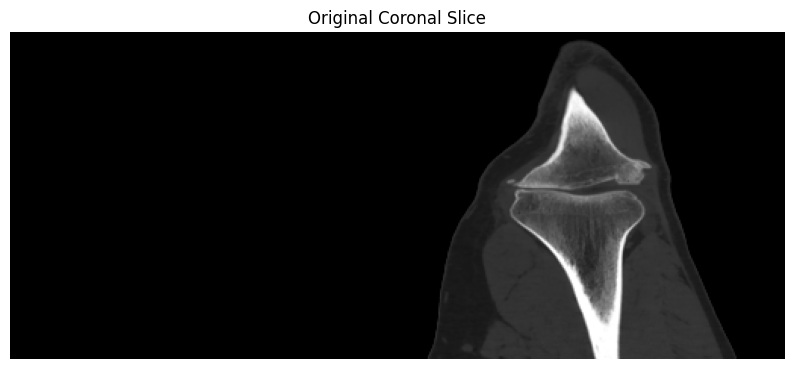

Segmenting knee CT...


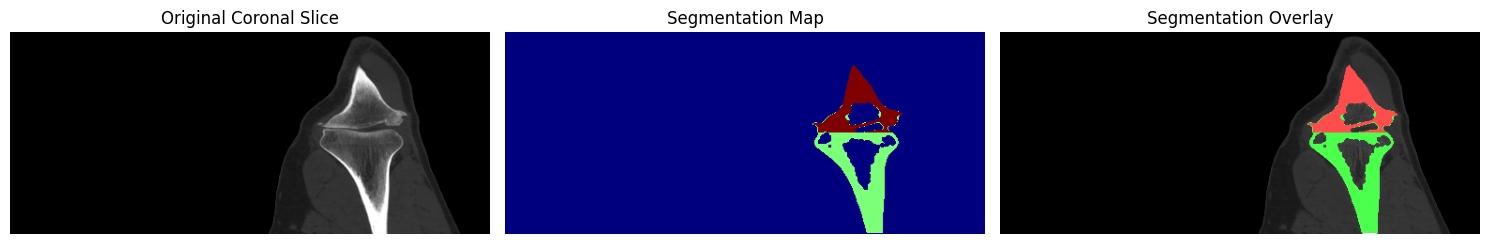

Segmentation saved to /content/drive/MyDrive/3702_left_knee_segmentation.nii.gz
Tibia volume: 274610 voxels (label 1, green)
Femur volume: 244016 voxels (label 2, red)


In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, morphology, measure, segmentation, feature

def segment_knee(input_path, output_path):
    """
    Segment the femur and tibia from a knee CT scan.

    Parameters:
    -----------
    input_path : str
        Path to the input NIfTI file
    output_path : str
        Path where the output segmentation should be saved

    Returns:
    --------
    numpy.ndarray
        The segmentation volume with labels: 0=background, 1=tibia, 2=femur
    """
    # Load the NIfTI file
    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()

    # Get image information
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    value_range = [np.min(data), np.max(data)]
    print(f"Value range: {value_range}")

    # Display original middle coronal slice
    coronal_idx = data.shape[1] // 2
    coronal_slice = data[:, coronal_idx, :]

    plt.figure(figsize=(10, 10))
    plt.imshow(coronal_slice.T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    plt.show()

    # Create empty segmentation volume
    segmentation_volume = np.zeros_like(data)

    # Set bone thresholds
    bone_threshold = 200

    # Process slices in the coronal plane (along y-axis)
    print("Segmenting knee CT...")

    # Focus on the central portion of the volume where the knee joint is
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)

    # First pass segmentation
    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]

        # Skip slices with no significant bone content
        if np.max(slice_data) < bone_threshold:
            continue

        # Create bone mask
        bone_mask = slice_data > bone_threshold
        bone_mask = morphology.remove_small_objects(bone_mask, min_size=50)
        bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))

        # Get image height
        height = slice_data.shape[1]

        # Find approximate joint position by analyzing vertical bone profile
        vertical_profile = np.sum(bone_mask, axis=0)
        smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)

        # Look for minima in middle third of image
        middle_start = height // 3
        middle_end = 2 * height // 3
        middle_profile = smooth_profile[middle_start:middle_end]

        # Find local minima
        if len(middle_profile) > 5:
            min_indices = []
            for j in range(2, len(middle_profile) - 2):
                if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]:
                    min_indices.append(j)

            if min_indices:
                # Find most significant minimum
                joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
                joint_position = middle_start + joint_idx

                # Create femur and tibia masks
                femur_mask = bone_mask.copy()
                femur_mask[:, joint_position:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :joint_position] = False
            else:
                # If no joint found, use middle point
                mid_point = height // 2

                femur_mask = bone_mask.copy()
                femur_mask[:, mid_point:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :mid_point] = False
        else:
            # Fallback to middle division
            mid_point = height // 2

            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False

            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False

        # Clean up masks
        femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)

        # Add to segmentation with CORRECT labels:
        # CRITICAL: Label 1 for tibia (will be green), Label 2 for femur (will be red)
        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2

    # Apply 3D post-processing
    # Extract femur and tibia masks using the correct labels
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2

    # Morphological operations for smoother results
    struct_element = np.ones((3, 3, 3))

    # Fill holes
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)

    # Smoothing
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)

    # Remove small objects
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)

    # Reconstruct final segmentation
    segmentation_volume = np.zeros_like(data)
    segmentation_volume[tibia_seg] = 1  # Tibia (green)
    segmentation_volume[femur_seg] = 2  # Femur (red)

    # Check if segmentation was successful
    tibia_volume = np.sum(tibia_seg)
    femur_volume = np.sum(femur_seg)

    # Apply fallback method if needed
    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")

        # More aggressive bone segmentation
        segmentation_volume = np.zeros_like(data)

        for i in range(start_slice, end_slice):
            slice_data = data[:, i, :]

            # Lower threshold
            bone_mask = slice_data > 150

            # Split at middle
            height = slice_data.shape[1]
            mid_point = height // 2

            # Create femur and tibia masks
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)

            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
            tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)

            # Add to segmentation - Tibia=1, Femur=2
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2

        # Reapply 3D post-processing
        tibia_seg = segmentation_volume == 1
        femur_seg = segmentation_volume == 2

        # Use larger structural elements
        tibia_seg = ndimage.binary_closing(tibia_seg, structure=np.ones((5, 5, 5)))
        femur_seg = ndimage.binary_closing(femur_seg, structure=np.ones((5, 5, 5)))

        tibia_seg = ndimage.binary_fill_holes(tibia_seg)
        femur_seg = ndimage.binary_fill_holes(femur_seg)

        tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
        femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)

        # Reconstruct final segmentation
        segmentation_volume = np.zeros_like(data)
        segmentation_volume[tibia_seg] = 1  # Tibia (green)
        segmentation_volume[femur_seg] = 2  # Femur (red)

    # Display segmentation results
    mid_slice = data.shape[1] // 2

    plt.figure(figsize=(15, 5))

    # Original slice
    plt.subplot(1, 3, 1)
    plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')

    # Segmentation map
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_volume[:, mid_slice, :].T, cmap='jet')
    plt.title('Segmentation Map')
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)

    # Create RGB overlay
    overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))

    # Normalize original image for background
    orig_slice = data[:, mid_slice, :].T
    orig_norm = np.clip(orig_slice, -300, 1500)
    orig_norm = (orig_norm - (-300)) / (1500 - (-300))

    # Set background grayscale
    overlay[:, :, 0] = orig_norm
    overlay[:, :, 1] = orig_norm
    overlay[:, :, 2] = orig_norm

    # Create masks for femur and tibia with CORRECT labels
    tibia_mask = segmentation_volume[:, mid_slice, :].T == 1
    femur_mask = segmentation_volume[:, mid_slice, :].T == 2

    # Set femur to RED (upper bone)
    overlay[femur_mask, 0] = 1.0  # Red
    overlay[femur_mask, 1] = 0.3  # Green
    overlay[femur_mask, 2] = 0.3  # Blue

    # Set tibia to GREEN (lower bone)
    overlay[tibia_mask, 0] = 0.3  # Red
    overlay[tibia_mask, 1] = 1.0  # Green
    overlay[tibia_mask, 2] = 0.3  # Blue

    plt.imshow(overlay)
    plt.title('Segmentation Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save segmentation as NIfTI file
    segmentation_nifti = nib.Nifti1Image(segmentation_volume.astype(np.int16), img.affine, img.header)
    segmentation_nifti.header.set_data_dtype(np.int16)
    nib.save(segmentation_nifti, output_path)
    print(f"Segmentation saved to {output_path}")

    # Report volumes
    tibia_volume = np.sum(segmentation_volume == 1)
    femur_volume = np.sum(segmentation_volume == 2)
    print(f"Tibia volume: {tibia_volume} voxels (label 1, green)")
    print(f"Femur volume: {femur_volume} voxels (label 2, red)")

    return segmentation_volume

# Main execution block
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"
    output_path = "/content/drive/MyDrive/3702_left_knee_segmentation.nii.gz"

    # Check if input file exists
    if not os.path.exists(input_path):
        print(f"Error: Input file {input_path} does not exist.")
    else:
        # Perform segmentation
        segmentation = segment_knee(input_path, output_path)